# Extractor de Características LBP

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from imutils import paths
import os

In [2]:
print(cv.__version__)

4.0.1


## Carga de la Imagen

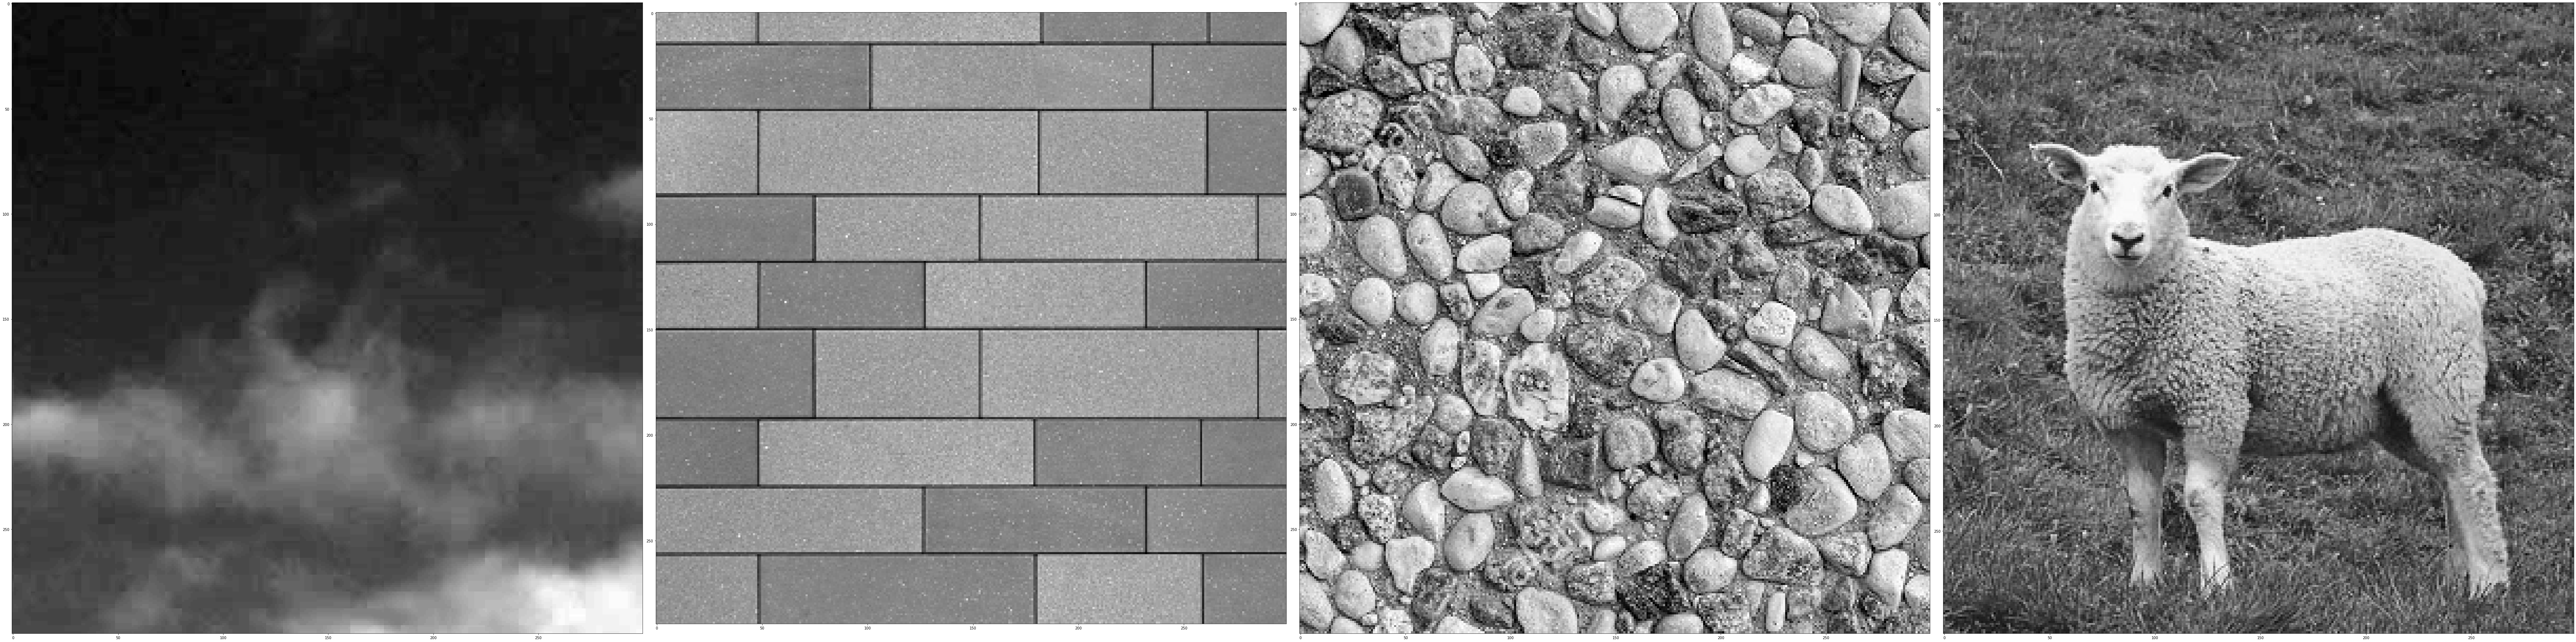

In [3]:
# Carga de Cielo
cielo_img = cv.imread('cielo.png')
cielo_gray = cv.cvtColor(cielo_img,cv.COLOR_BGR2GRAY)
# cielo_gray = cv.medianBlur(cielo_gray,5)

# Carga de ladrillos
ladrillos1_img = cv.imread('ladrillos1.png')
ladrillos1_gray = cv.cvtColor(ladrillos1_img,cv.COLOR_BGR2GRAY)
# ladrillos1_gray = cv.medianBlur(ladrillos1_gray,5)
ladrillos2_img = cv.imread('ladrillos2.png')
ladrillos2_gray = cv.cvtColor(ladrillos2_img,cv.COLOR_BGR2GRAY)
# ladrillos1_gray = cv.medianBlur(ladrillos1_gray,5)

# Carga de piedras
piedras1_img = cv.imread('piedras1.png')
piedras1_gray = cv.cvtColor(piedras1_img,cv.COLOR_BGR2GRAY)
piedras2_img = cv.imread('piedras2.png')
piedras2_gray = cv.cvtColor(piedras2_img,cv.COLOR_BGR2GRAY)

# Carga de ovejas
oveja1_img = cv.imread('oveja1.png')
oveja1_gray = cv.cvtColor(oveja1_img,cv.COLOR_BGR2GRAY)
oveja2_img = cv.imread('oveja2.png')
oveja2_gray = cv.cvtColor(oveja2_img,cv.COLOR_BGR2GRAY)

# Plot de las imágenes
fig=plt.figure(figsize=(100, 100))
fig.add_subplot(1,4,1)
plt.imshow(cielo_gray, 'gray')
fig.add_subplot(1,4,2)
plt.imshow(ladrillos1_gray,'gray')
fig.add_subplot(1,4,3)
plt.imshow(piedras1_gray,'gray')
fig.add_subplot(1,4,4)
plt.imshow(oveja1_gray,'gray')
fig.tight_layout()    

plt.show()

## Extractor LBP

### Padding Verificación

(300, 300)
(302, 302)


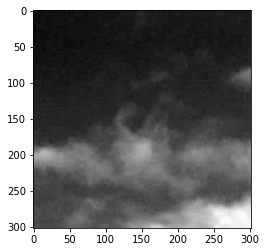

In [4]:
print(cielo_gray.shape)
border = 1
borderType = cv.BORDER_REPLICATE
cielo_gray_padding = cv.copyMakeBorder(cielo_gray, border, border, border, border, borderType, None, None)
print(cielo_gray_padding.shape)
plt.imshow(cielo_gray_padding,'gray')
plt.show()

### LBP Implementación

(299, 299)


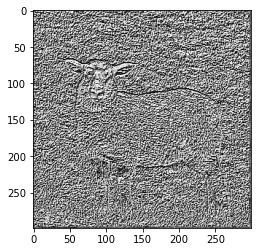

In [5]:
def LocalBinaryValue(img, i, j, binary_mask):
    # Gets the LBP value for a given pixel using an arrange of 9 
    window = img[i-1:i+2, j-1:j+2]
    mask = window >=img[i,j] 
    result = np.sum((binary_mask * mask).flatten())
    return result

def LBP(img):
    # Standard LBP implementation without uniformity
    # Padding
    border = 1
    borderType = cv.BORDER_REPLICATE
    img_padding = cv.copyMakeBorder(img, border, border, border, border, borderType, None, None)
    # Binary weights 
    binary_mask = np.array([128, 64, 32, 1, 0, 16, 2, 4, 8]).reshape(3, 3)
    # Image for LBP characteristic
    img_lbp = img.copy()
    for i in np.arange(1, img.shape[0]-1):
        for j in np.arange(1, img.shape[1]-1):
                img_lbp.itemset((i-1, j-1),LocalBinaryValue(img_padding, i, j, binary_mask))
    return img_lbp

lbp_oveja1 = LBP(oveja1_gray)            
print(lbp_oveja1.shape)
plt.imshow(lbp_oveja1,'gray')
plt.show()

### Histograma

In [6]:
def histogram(lbp, name):
    hist, bin_edges, _ = plt.hist(lbp.flatten(), bins=255, range=(0, 255), density=True)
    plt.title("Histogram of {name}".format(name=name))
    return hist, bin_edges

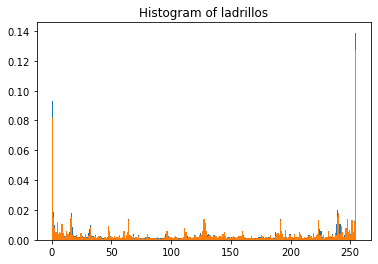

In [7]:
# Histogram comparision
# Get the LBP characteristics
lbp_oveja2 = LBP(oveja2_gray)
lbp_piedras1 = LBP(piedras1_gray)
lbp_piedras2 = LBP(piedras2_gray)
lbp_ladrillos1 = LBP(ladrillos1_gray)
lbp_ladrillos2 = LBP(ladrillos2_gray)

# Get histograms
# hist_1, bin_1 = histogram(lbp_oveja1, "oveja1")
# hist_2, bin_2 = histogram(lbp_oveja2, "oveja2")
# hist_1, bin_1 = histogram(lbp_piedras1, "piedras1")
# hist_2, bin_2 = histogram(lbp_piedras2, "piedras2")
hist_1, bin_1 = histogram(lbp_ladrillos1, "ladrillos")
hist_2, bin_2 = histogram(lbp_ladrillos2, "ladrillos")
plt.show()

#### Como se puede observar, ambos histogramas (rojo y azul) son similares. 

## Clasificador SVM con características LBP

In [8]:
# Create a function that return directly the histogram of the LBP image
def LBP_Histogram(img):
    img_lbp = LBP(img)
    hist, _ = np.histogram(img_lbp.flatten(), bins=255, range=(0, 255))
    return hist

In [9]:
# Variables for classifier
data = []
labels = []

In [10]:
# Training Stage
from sklearn.svm import LinearSVC

for imagePath in paths.list_images("training"):
    label = os.path.split(imagePath)[1].split(".")[0].split("_")[0]
    labels.append(label)
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    hist = LBP_Histogram(gray)
    data.append(hist)

model = LinearSVC(C=100.0, random_state=42)
model.fit(data, labels)

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=100.0, random_state=42)

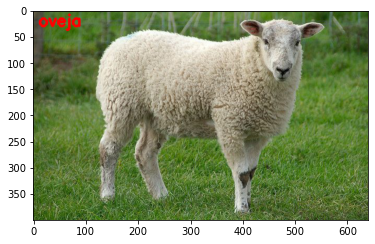

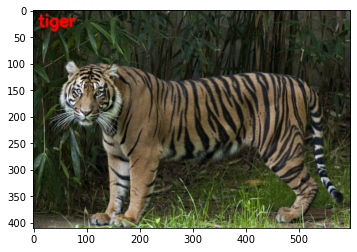

In [12]:
# Predictions
for imagePath in paths.list_images("testing"):
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    hist = LBP_Histogram(gray)
    prediction = model.predict(hist.reshape(1, -1))
    
    # display the image and the prediction
    cv.putText(img, prediction[0], (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
    plt.imshow(img[:, :, ::-1])
    plt.show()